In [1]:
import scipy.stats as ss

In [13]:
%matplotlib inline

## Example with n x 1 data

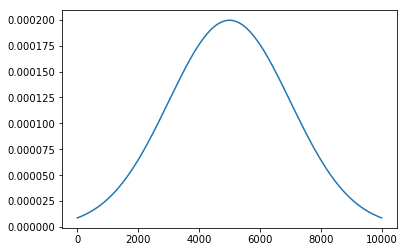

In [14]:
## create some input data
import matplotlib.pyplot as plt
import scipy.stats as ss

array_length = 10000

xs = range(array_length)
array_data = [ss.norm.pdf(i, array_length/2, array_length/5) for i in xs]
plt.plot(xs, array_data)

In [25]:
import h5py 
import math
import os
import os.path as op
import numpy as np

def create_multires(array_data, array_length, agg, starting_resolution=1):
    '''
    Create a multires file containing the array data
    aggregated at multiple resolutions.
    
    Parameters
    ----------
    array_data: np.array
        The array data to aggregate
    array_length: int
        The length of the array to aggregate
    agg: lambda
        The function that will aggregate the data. Should
        take an array as input and create another array of
        roughly half the length
    starting_resolution: int (default 1)
        The starting resolution of the input data
    '''
    filename = '/tmp/my_file.multires'

    # this is just so we can run this code
    # multiple times without h5py complaining
    if op.exists(filename):
        os.remove(filename)

    # this will be the file that contains our multires data
    f = h5py.File('/tmp/my_file.multires', 'w')
    f.create_group('resolutions')

    # start with a resolution of 1 element per pixel
    curr_resolution = starting_resolution

    # this will be our sample highest-resolution array
    # and it will be stored under the resolutions['1']
    # dataset
    f['resolutions'].create_dataset(str(curr_resolution), array_data.shape)
    f['resolutions'][str(curr_resolution)][:] = array_data    # see above section

    # the tile size that we want higlass to use
    # unless this needs to be drastically different, there's no
    # reason to change it
    tile_size = 1024

    # the maximum zoom level corresponds to the number of aggregations
    # that need to be performed so that the entire extent of
    # the dataset fits into one tile
    max_zoom = math.ceil(math.log(array_length / (tile_size * starting_resolution) ) / math.log(2))
    print("max_zoom:", max_zoom)
    
    # we're going to go through and create the data for the different
    # zoom levels by summing adjacent data points
    prev_resolution = curr_resolution

    for i in range(max_zoom):
        # each subsequent zoom level will have half as much data
        # as the previous
        curr_resolution = prev_resolution * 2

        next_level_length = math.ceil(
            len(f['resolutions'][str(prev_resolution)]) / 2)
        
        old_data = f['resolutions'][str(prev_resolution)][:]
        
        # this is a sort of roundabout way of calculating the 
        # shape of the aggregated array, but all its doing is
        # just halving the first dimension of the previous shape
        # without taking into account the other dimensions
        new_shape = list(old_data.shape)
        new_shape[0] = math.ceil(new_shape[0] / 2)
        new_shape = tuple(new_shape)
        
        f['resolutions'].create_dataset(str(curr_resolution), 
                                        new_shape)

        if len(old_data) % 2 != 0:
            # we need our array to have an even number of elements
            # so we just add the last element again
            old_data = np.append(old_data, [old_data[-1]])

        # actually sum the adjacent elements
        new_data = agg(old_data)

        print("zoom_level:", max_zoom - 1 - i, 
              "resolution:", curr_resolution, 
              "new_data length", len(new_data))
        f['resolutions'][str(curr_resolution)][:] = new_data

        prev_resolution = curr_resolution
    return f

f = create_multires(np.array(array_data), 
                    len(array_data),
                    lambda x: x.reshape(-1,2).sum(axis=1))

max_zoom: 4
zoom_level: 3 resolution: 2 new_data length 5000
zoom_level: 2 resolution: 4 new_data length 2500
zoom_level: 1 resolution: 8 new_data length 1250
zoom_level: 0 resolution: 16 new_data length 625


In [26]:
f = create_multires(np.array(array_data), 
                    len(array_data),
                    lambda x: x.reshape(-1,2).sum(axis=1),
                    starting_resolution = 3)

max_zoom: 4
zoom_level: 3 resolution: 6 new_data length 5000
zoom_level: 2 resolution: 12 new_data length 2500
zoom_level: 1 resolution: 24 new_data length 1250
zoom_level: 0 resolution: 48 new_data length 625


In [16]:
def get_tileset_info(f):
    '''
    Return some information about this tileset that will
    help render it in on the client.
    
    Parameters
    ----------
    f: h5py.File
        The f for which we're returning tileset info
    
    Returns
    -------
    tileset_info: {}
        A dictionary containing the information describing
        this dataset
    '''
    # a sorted list of resolutions, lowest to highest
    # awkward to write because a the numbers representing resolution
    # are datapoints / pixel so lower resolution is actually a higher
    # number
    resolutions = sorted([int(r) for r in f['resolutions'].keys()])[::-1]
    
    # the "leftmost" datapoint position
    # an array because higlass can display multi-dimensional
    # data
    min_pos = [0]
    
    # the "rightmost" datapoint position
    max_pos = [len(f['resolutions'][str(resolutions[-1])])]
    tile_size = 1024
    
    return {
        'resolutions': resolutions,
        'min_pos': min_pos, 
        'tile_size': tile_size
    }

In [17]:
print(get_tileset_info(f))

{'resolutions': [16, 8, 4, 2, 1], 'min_pos': [0], 'tile_size': 1024}


In [7]:
def get_tile(f, tile_pos):
    '''
    Return a data tile from a multires file.
    
    Parameters
    ----------
    f: h5py.File
        A multires datafile
    tile_pos: []
        An array containing the zoom level and tile
        position (e.g. [0,3])
        
    Returns
    -------
    data: []
        The data for that tile as an array
    '''
    tileset_info = get_tileset_info(f)
    
    # which resolution does this zoom level correspond to?
    resolution = tileset_info['resolutions'][tile_pos[0]]
    tile_size = tileset_info['tile_size']
    
    # where in the data does the tile start and end
    tile_start = tile_pos[1] * tile_size
    tile_end = tile_start + tile_size

    return f['resolutions'][str(resolution)][tile_start:tile_end]

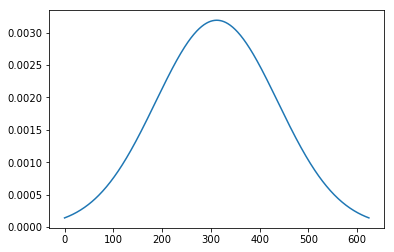

In [8]:
# the largest tile (zoom level 0, position 0) contains a downsampled
# version of the entire dataset
d = get_tile(f, [0,0])
plt.plot(d)

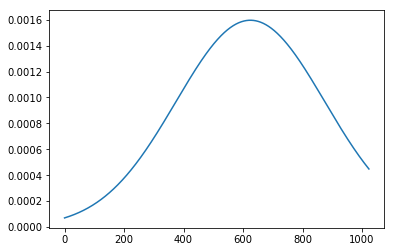

In [9]:
# going to the first tile of the next zoom level
# we're showing less data
d = get_tile(f, [1,0])
plt.plot(d)

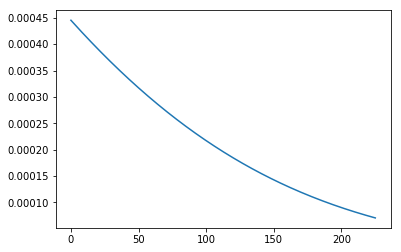

In [10]:
# the second tile of zoom_level 1 contains the
# data to the "right" of the first tile
d = get_tile(f, [1,1])
plt.plot(d)

## Example with n x c data

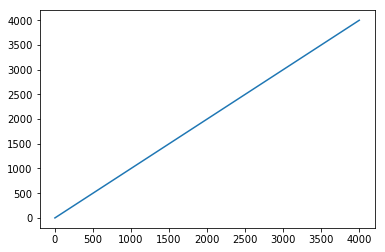

In [11]:
## create some input data
import h5py 
import math
import os
import os.path as op
import numpy as np

import matplotlib.pyplot as plt
import scipy.stats as ss

array_length = 4000
array_width = 5

xs = range(array_length)
array_data = np.array([i * np.array(range(array_length))
              for i in range(1,array_width+1)]).T
plt.plot(xs, array_data[:,0])

In [12]:
array_data

array([[    0,     0,     0,     0,     0],
       [    1,     2,     3,     4,     5],
       [    2,     4,     6,     8,    10],
       ..., 
       [ 3997,  7994, 11991, 15988, 19985],
       [ 3998,  7996, 11994, 15992, 19990],
       [ 3999,  7998, 11997, 15996, 19995]])

In [13]:
array_data.T.reshape((array_data.shape[1],-1,2)).sum(axis=2).T

array([[    1,     2,     3,     4,     5],
       [    5,    10,    15,    20,    25],
       [    9,    18,    27,    36,    45],
       ..., 
       [ 7989, 15978, 23967, 31956, 39945],
       [ 7993, 15986, 23979, 31972, 39965],
       [ 7997, 15994, 23991, 31988, 39985]])

In [14]:
f = create_multires(np.array(array_data), 
                    array_length,
                    lambda x: x.T.reshape((x.shape[1],-1,2)).sum(axis=2).T)

zoom_level: 1 resolution: 2 new_data length 2000
zoom_level: 0 resolution: 4 new_data length 1000


In [15]:
print(get_tileset_info(f))

{'resolutions': [4, 2, 1], 'min_pos': [0], 'tile_size': 1024}


In [16]:
get_tile(f, [0,0])

array([[  6.00000000e+00,   1.20000000e+01,   1.80000000e+01,
          2.40000000e+01,   3.00000000e+01],
       [  2.20000000e+01,   4.40000000e+01,   6.60000000e+01,
          8.80000000e+01,   1.10000000e+02],
       [  3.80000000e+01,   7.60000000e+01,   1.14000000e+02,
          1.52000000e+02,   1.90000000e+02],
       ..., 
       [  1.59580000e+04,   3.19160000e+04,   4.78740000e+04,
          6.38320000e+04,   7.97900000e+04],
       [  1.59740000e+04,   3.19480000e+04,   4.79220000e+04,
          6.38960000e+04,   7.98700000e+04],
       [  1.59900000e+04,   3.19800000e+04,   4.79700000e+04,
          6.39600000e+04,   7.99500000e+04]], dtype=float32)